In [1]:
import copy
import itertools
import pickle
import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold, PredefinedSplit
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight, compute_sample_weight

SEED = 42


def fix_random(seed: int) -> None:
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True  # slower


fix_random(SEED)

if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')
# device = torch.device('cpu')

print('Using device:', device)

Using device: cuda


## Load the dataset

In [2]:
save_in_test_folder = True
if save_in_test_folder:
    filepath = "../TestModule"
else:
    filepath = "."

seed = 42
FILENAME = "dataset/train_dataset.csv"

#Prepare train data
df1 = pd.read_csv(FILENAME, sep=",", low_memory=False)

# get features names
features = list(df1.columns)
# features_to_remove = ["label", "ts", "src_ip", "dst_ip", "dns_query", "ssl_subject", "ssl_issuer", "http_uri", "type", "http_referrer", "http_user_agent"]
features_to_remove = ["label", "type", "ts", "http_referrer"]
features = [feature for feature in features if feature not in features_to_remove]
df1 = df1[features + ["type"]]

# Converte i valori in numeri, sostituendo quelli non validi con NaN
df1["src_bytes"] = pd.to_numeric(df1["src_bytes"], errors='coerce')
# Filtra le righe con NaN (valori non convertibili)
df1 = df1.dropna(subset=["src_bytes"])
# Converte i valori rimasti in interi
df1.loc[:, "src_bytes"] = df1["src_bytes"].astype(int)

print("#Righe: " + str(df1.shape[0]) + " #Colonne: " + str(df1.shape[1]))
df1 = df1.dropna()
print("#Righe: " + str(df1.shape[0]) + " #Colonne: " + str(df1.shape[1]))

X = df1[features]
y = df1["type"]

le = preprocessing.LabelEncoder()
le.fit(y)
with open(f"{filepath}/transformer/target_encoder.save", "wb") as f:
    pickle.dump(le, f)

y = le.transform(y)

indices = np.arange(X.shape[0])
train_idx, val_idx = train_test_split(indices, test_size=0.2, stratify=y, random_state=seed)

# fold = np.zeros(X.shape[0])
# fold[train_idx] = -1

n_splits = 10
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

fold = np.full(len(y), -1)  # Inizializza tutto con -1 (default: train)

# Assegna i fold ai campioni
for fold_number, (_, val_idx) in enumerate(skf.split(X, y)):
    fold[val_idx] = fold_number  # Assegna il numero del fold ai campioni di validazione

ps = PredefinedSplit(fold)
ps.get_n_splits()

# for i, (train_index, test_index) in enumerate(ps.split()):
#     print(f"Fold {i}:")
#     print(f"  Train: index={train_index}")
#     print(f"  Test:  index={test_index}")

# take only x with index in val_idx
X_val = X.iloc[val_idx]
y_val = y[val_idx]
X_train = X.iloc[train_idx]
y_train = y[train_idx]

#Righe: 616983 #Colonne: 43
#Righe: 616983 #Colonne: 43


## Preprocessing

In [3]:
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

import pickle

categorical_columns = X_train.select_dtypes(include=["object"]).columns.tolist()
numeric_columns = X_train.select_dtypes(include=["int64", "float64"]).columns.tolist()
# boolean_columns = X_train.select_dtypes(include=["bool"]).columns.tolist()

class CustomOrdinalEncoder(OrdinalEncoder):
    def transform(self, X):
        encoded = super().transform(X)
        # Shift all values by +1 and replace unknown_value (-1) with 0
        return np.where(encoded == -1, 0, encoded + 1)

    def inverse_transform(self, X):
        # Handle the inverse transform to account for the +1 offset
        X = np.where(X == 0, -1, X - 1)
        return super().inverse_transform(X)


ct = ColumnTransformer(
    [
        ("cat", CustomOrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), categorical_columns),  # Trasforma le colonne categoriche
        # ("ordinal", OneHotEncoder(handle_unknown='infrequent_if_exist', sparse_output=False), categorical_columns),  # Trasforma le colonne categoriche
        ("scale", StandardScaler(), numeric_columns)  # Normalizza le colonne numeriche
    ],
    remainder="passthrough"  # Mantieni le altre colonne invariate
)
ct.set_output(transform="pandas")

ct = ct.fit(X_train)
with open(f"{filepath}/transformer/transformer_tb.save", "wb") as f:
    pickle.dump(ct, f)

# train set
X_train = ct.transform(X_train)
cat_idxs = [i for i, f in enumerate(X_train.columns) if "cat__" in f]
cat_dims = [len(X_train[f].unique()) + 1 for i, f in enumerate(X_train.columns) if "cat__" in f]

# validation set
X_val = ct.transform(X_val)

# X
X = ct.transform(X)

#### DEFINE WEIGHTS FOR UNBALANCED CLASSES

In [4]:
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(class_weights))
sample_weight = compute_sample_weight(class_weight='balanced', y=y_train)
print(class_weights)

{0: 4.069469865611345, 1: 0.3381003918130257, 2: 1.132545546326465, 3: 4.543735616312253, 4: 98.7172, 5: 2.9863625363020327, 6: 1.1966881637007225, 7: 63.85329883570505, 8: 0.28803534018428717, 9: 0.9751965859248429}


# TabNet

In [5]:
from pytorch_tabnet.tab_model import TabNetClassifier
from pytorch_tabnet.pretraining import TabNetPretrainer


class TabNet(torch.nn.Module):
    '''
    Wrapper class for TabNetClassifier
    '''

    def __init__(self, n_d,
                 n_a,
                 n_steps,
                 gamma,
                 optimizer_fn,
                 n_independent,
                 n_shared,
                 epsilon,
                 seed,
                 lambda_sparse,
                 clip_value,
                 momentum,
                 optimizer_params,
                 scheduler_params,
                 mask_type,
                 scheduler_fn,
                 device_name,
                 output_dim,
                 batch_size,
                 num_epochs,
                 unsupervised_model,
                 cat_idxs=None,
                 cat_dims=None,
                 verbose=0):
        super(TabNet, self).__init__()

        self.batch_size = batch_size
        self.num_epochs = num_epochs
        self.unsupervised_model = unsupervised_model
        self.network = TabNetClassifier(n_d=n_d,
                                        n_a=n_a,
                                        n_steps=n_steps,
                                        gamma=gamma,
                                        optimizer_fn=optimizer_fn,
                                        n_independent=n_independent,
                                        n_shared=n_shared,
                                        epsilon=epsilon,
                                        seed=seed,
                                        lambda_sparse=lambda_sparse,
                                        clip_value=clip_value,
                                        momentum=momentum,
                                        optimizer_params=optimizer_params,
                                        scheduler_params=scheduler_params,
                                        mask_type=mask_type,
                                        scheduler_fn=scheduler_fn,
                                        device_name=device_name,
                                        output_dim=output_dim,
                                        verbose=verbose,
                                        cat_idxs=cat_idxs,
                                        cat_dims=cat_dims,
                                        # cat_emb_dim=20
                                        )

    def fit_model(self, X_train, y_train, X_val, y_val, criterion):
        self.network.fit(X_train=X_train,
                         y_train=y_train,
                         eval_set=[(X_train, y_train), (X_val, y_val)],
                         eval_metric=['balanced_accuracy'],
                         patience=10,
                         batch_size=self.batch_size,
                         virtual_batch_size=128,
                         num_workers=0,
                         drop_last=True,
                         max_epochs=self.num_epochs,
                         loss_fn=criterion,
                         from_unsupervised=self.unsupervised_model)

    def predict(self, X):
        return self.network.predict(X)

    def explain(self, X):
        return self.network.explain(X)

    def feature_importances(self):
        return self.network.feature_importances_


def get_unsupervised_model(n_d_a, n_step, n_independent, n_shared, gamma, lr, cat_idxs=None, cat_dims=None):
    tabnet_params = dict(n_d=n_d_a,
                         n_a=n_d_a,
                         n_steps=n_step,
                         gamma=gamma,
                         n_independent=n_independent,
                         n_shared=n_shared,
                         lambda_sparse=1e-3,
                         optimizer_fn=torch.optim.AdamW,
                         optimizer_params=dict(lr=lr),
                         mask_type="sparsemax",
                         verbose=1,
                         cat_idxs=cat_idxs,
                         cat_dims=cat_dims
                         )
    return TabNetPretrainer(**tabnet_params)

#### HYPERPARAMETERS CONFIGURATION

In [6]:
nums_epochs = [1000]
batch_sizes = [1024*6]
patience = [20]
n_d_a = [64]  # 8, 16, 32, 64
n_shared = [1]  # 1, 2, 3, 4, 5
n_indipendents = [1]  # 1, 2, 3, 4, 5
n_steps = [8]  # 3, 4, 5, 6, 7, 8, 9, 10
gamma = [1.1]  # 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0
epsilon = [1e-15]
learning_rate = [0.001]
pretraining_ratio = [0.5]
momentum = [0.02]
hyperparameters = list(itertools.product(nums_epochs, batch_sizes, patience, n_d_a, n_indipendents, n_shared, n_steps, gamma, epsilon, learning_rate, pretraining_ratio, momentum))
n_comb = len(hyperparameters)
print(f'Number of hyperparameter combinations: {n_comb}')

Number of hyperparameter combinations: 1


## Training

In [7]:
current_iter = 0
best_acc = 0
criterion = torch.nn.CrossEntropyLoss(weight=torch.tensor(list(class_weights.values()), dtype=torch.float32).to(device))

# unsupervised_model = get_unsupervised_model(n_d_a=64, n_step=8, n_independent=1, n_shared=1, gamma=1.1, lr=0.001, cat_idxs=None, cat_dims=None)
unsupervised_model = get_unsupervised_model(n_d_a=64, n_step=8, n_independent=1, n_shared=1, gamma=1.1, lr=0.001, cat_idxs=cat_idxs, cat_dims=cat_dims)

unsupervised_model.fit(
    X_train=X_train.values,
    eval_set=[X_val.values],
    max_epochs=1000,
    patience=20,
    batch_size=1024*20,
    virtual_batch_size=128*20,
    drop_last=False,
    num_workers=0,
    pretraining_ratio=0.5,
)

with open(f"{filepath}/models/tabnet_unsupervised_model.save", "wb") as f:
    pickle.dump(unsupervised_model, f)

# with open(f"{filepath}/models/tabnet_unsupervised_model.save", "rb") as f:
#     unsupervised_model = pickle.load(f)

for num_epochs, batch_size, patience_, n_d, n_i, n_s, n_steps_, gamma_, epsilon_, lr, pretraining_ratio_, moment in hyperparameters:
    print(f'Iteration {current_iter + 1}/{n_comb}')
    print(f'Hyperparameters: num_epochs={num_epochs}, batch_size={batch_size}, patience={patience_}, n_d={n_d}, n_indipendent={n_i}, n_shared={n_s}, n_steps={n_steps_}, gamma={gamma_}, epsilon={epsilon_}, lr={lr}, pretraining_ratio={pretraining_ratio_}, momentum={moment}')

    model = TabNet(n_d=n_d,
                   n_a=n_d,
                   n_steps=n_steps_,
                   gamma=gamma_,
                   optimizer_fn=torch.optim.AdamW,
                   n_independent=n_i,
                   n_shared=n_s,
                   epsilon=epsilon_,
                   seed=SEED,
                   lambda_sparse=1e-4,
                   clip_value=1,
                   momentum=moment,
                   optimizer_params=dict(lr=lr),
                   scheduler_params=dict(step_size=10, gamma=0.9),
                   mask_type='sparsemax',
                   scheduler_fn=torch.optim.lr_scheduler.StepLR,
                   device_name=device,
                   output_dim=len(np.unique(y_train)),
                   batch_size=batch_size,
                   num_epochs=num_epochs,
                   unsupervised_model=unsupervised_model,
                   verbose=1,
                   cat_idxs=cat_idxs,
                   cat_dims=cat_dims
                   )
    model.fit_model(X_train.values, y_train, X_val.values, y_val, criterion)
    y_pred = model.predict(X_val.values)
    acc = accuracy_score(y_val, y_pred)
    if acc > best_acc:
        best_acc = acc
        best_model = copy.deepcopy(model)
        best_hyperparameters = f"num_epochs={num_epochs}, batch_size={batch_size}, patience={patience_}, n_d={n_d}, n_indipendent={n_i}, n_shared={n_s}, n_steps={n_steps_}, gamma={gamma_}, epsilon={epsilon_}, lr={lr}, pretraining_ratio={pretraining_ratio_}, momentum={moment}"
        with open(f"{filepath}/models/tabnet_model4.save", "wb") as f:
            pickle.dump(best_model, f)
    current_iter += 1

C:\Users\miaob\PycharmProjects\DataAnalyticsProject\Lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 8455794.19553| val_0_unsup_loss_numpy: 96658.6640625|  0:00:11s
epoch 1  | loss: 86905611.45289| val_0_unsup_loss_numpy: 133602.953125|  0:00:22s
epoch 2  | loss: 222420.62508| val_0_unsup_loss_numpy: 56587.453125|  0:00:34s
epoch 3  | loss: 65282526.34247| val_0_unsup_loss_numpy: 36872.2578125|  0:00:45s
epoch 4  | loss: 19580495.89124| val_0_unsup_loss_numpy: 11183.1435546875|  0:00:56s
epoch 5  | loss: 6400773.04992| val_0_unsup_loss_numpy: 27969.912109375|  0:01:07s
epoch 6  | loss: 2930633.13577| val_0_unsup_loss_numpy: 20783.54296875|  0:01:18s
epoch 7  | loss: 32822.79978| val_0_unsup_loss_numpy: 18025.90234375|  0:01:29s
epoch 8  | loss: 7971578.78941| val_0_unsup_loss_numpy: 21645.974609375|  0:01:40s
epoch 9  | loss: 1591881.46018| val_0_unsup_loss_numpy: 3235.4541015625|  0:01:51s
epoch 10 | loss: 28982717.14857| val_0_unsup_loss_numpy: 14302.8349609375|  0:02:02s
epoch 11 | loss: 55351988.00142| val_0_unsup_loss_numpy: 2649.544677734375|  0:02:13s
epoch 12 

C:\Users\miaob\PycharmProjects\DataAnalyticsProject\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Iteration 1/1
Hyperparameters: num_epochs=1000, batch_size=6144, patience=20, n_d=64, n_indipendent=1, n_shared=1, n_steps=8, gamma=1.1, epsilon=1e-15, lr=0.001, pretraining_ratio=0.5, momentum=0.02


C:\Users\miaob\PycharmProjects\DataAnalyticsProject\Lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
C:\Users\miaob\PycharmProjects\DataAnalyticsProject\Lib\site-packages\pytorch_tabnet\abstract_model.py:248: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")


epoch 0  | loss: 3.99556 | val_0_balanced_accuracy: 0.25618 | val_1_balanced_accuracy: 0.25501 |  0:01:01s
epoch 1  | loss: 1.92049 | val_0_balanced_accuracy: 0.43925 | val_1_balanced_accuracy: 0.43754 |  0:02:02s
epoch 2  | loss: 1.46251 | val_0_balanced_accuracy: 0.53651 | val_1_balanced_accuracy: 0.52676 |  0:03:04s
epoch 3  | loss: 1.25704 | val_0_balanced_accuracy: 0.56074 | val_1_balanced_accuracy: 0.55395 |  0:04:07s
epoch 4  | loss: 1.14197 | val_0_balanced_accuracy: 0.59959 | val_1_balanced_accuracy: 0.59942 |  0:05:09s
epoch 5  | loss: 1.04951 | val_0_balanced_accuracy: 0.63001 | val_1_balanced_accuracy: 0.62408 |  0:06:11s
epoch 6  | loss: 0.96159 | val_0_balanced_accuracy: 0.64473 | val_1_balanced_accuracy: 0.64027 |  0:07:12s
epoch 7  | loss: 0.89699 | val_0_balanced_accuracy: 0.72923 | val_1_balanced_accuracy: 0.72885 |  0:08:14s
epoch 8  | loss: 0.84795 | val_0_balanced_accuracy: 0.67711 | val_1_balanced_accuracy: 0.663   |  0:09:16s
epoch 9  | loss: 0.81878 | val_0_bala

C:\Users\miaob\PycharmProjects\DataAnalyticsProject\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


## TEST

In [ ]:
# print(f'Best model hyperparameters: {best_hyperparameters}')
# y_pred = best_model.predict(X_test)
# acc = accuracy_score(y_test, y_pred)
# print(f'Accuracy: {acc}\n')

## Explainability

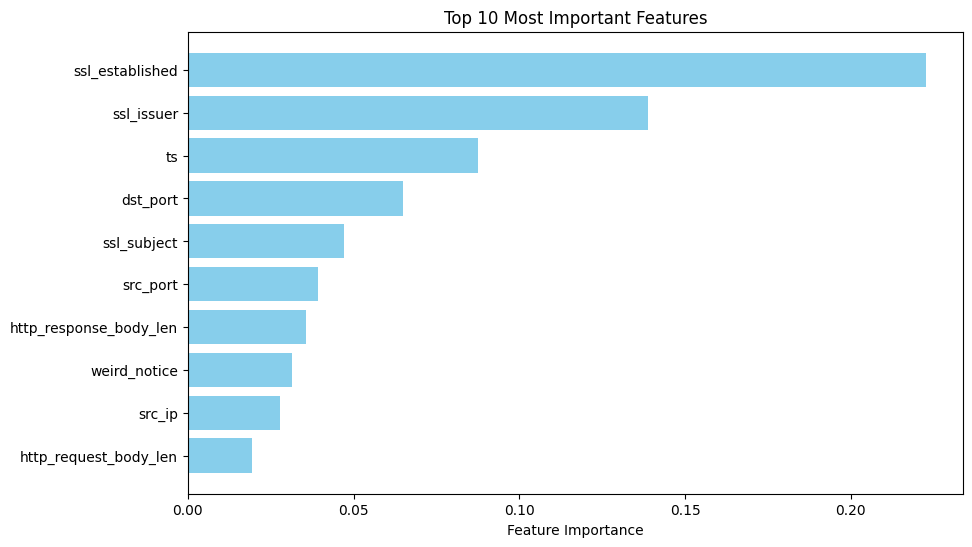

In [79]:
# Assuming `feature_importances` is a numpy array containing the importance values
# and `feature_names` is a list of names corresponding to the features
feature_importances = best_model.network.feature_importances_
feature_names = df1.drop(columns=['type']).columns

# Sort the feature importances in descending order and select the top 10
indices = np.argsort(feature_importances)[-10:][::-1]
top_features = feature_importances[indices]
top_feature_names = feature_names[indices]

# Plotting
plt.figure(figsize=(10, 6))
plt.barh(top_feature_names, top_features, color='skyblue')
plt.xlabel("Feature Importance")
plt.title("Top 10 Most Important Features")
plt.gca().invert_yaxis()  # To show the most important feature at the top
plt.show()

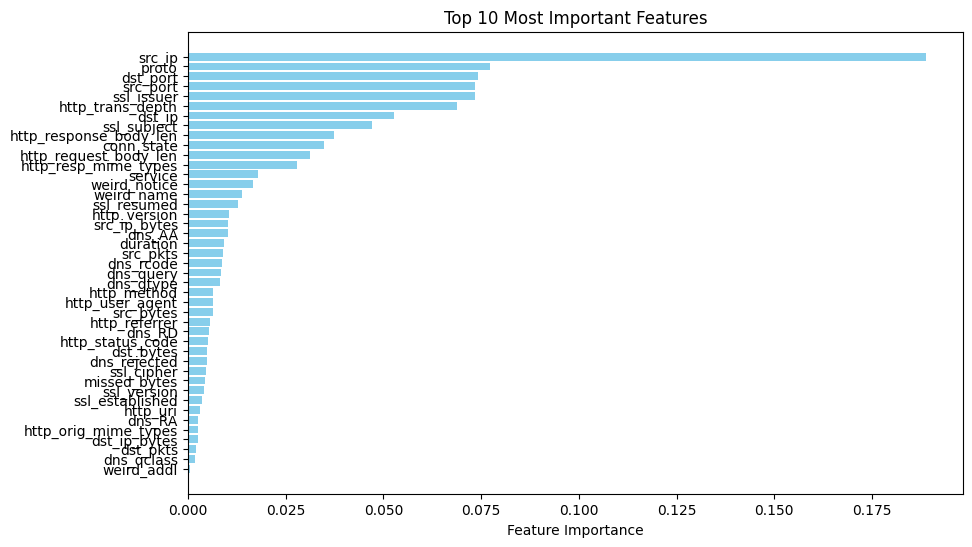

In [11]:
# Assuming `feature_importances` is a numpy array containing the importance values
# and `feature_names` is a list of names corresponding to the features
feature_importances = best_model.network.feature_importances_
feature_names = df1.drop(columns=['type']).columns

# Sort the feature importances in descending order and select the top 10
indices = np.argsort(feature_importances)[-50:][::-1]
top_features = feature_importances[indices]
top_feature_names = feature_names[indices]

# Plotting
plt.figure(figsize=(10, 6))
plt.barh(top_feature_names, top_features, color='skyblue')
plt.xlabel("Feature Importance")
plt.title("Top 10 Most Important Features")
plt.gca().invert_yaxis()  # To show the most important feature at the top
plt.show()

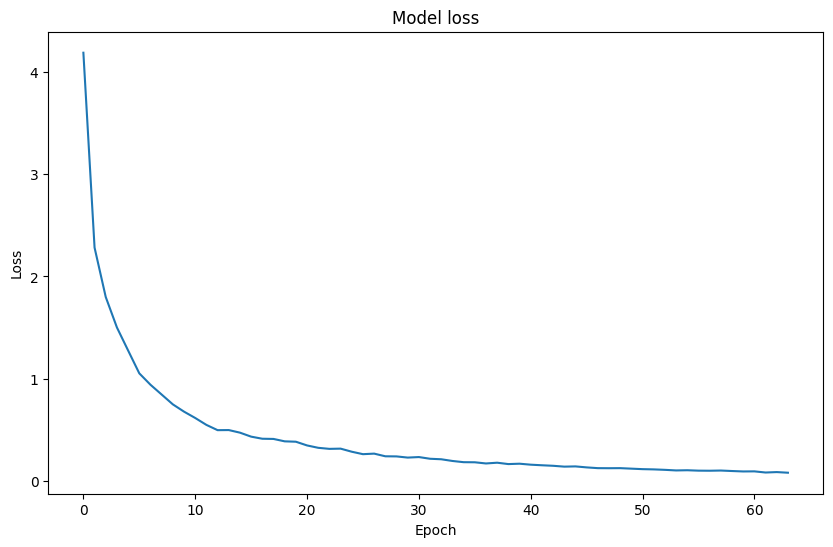

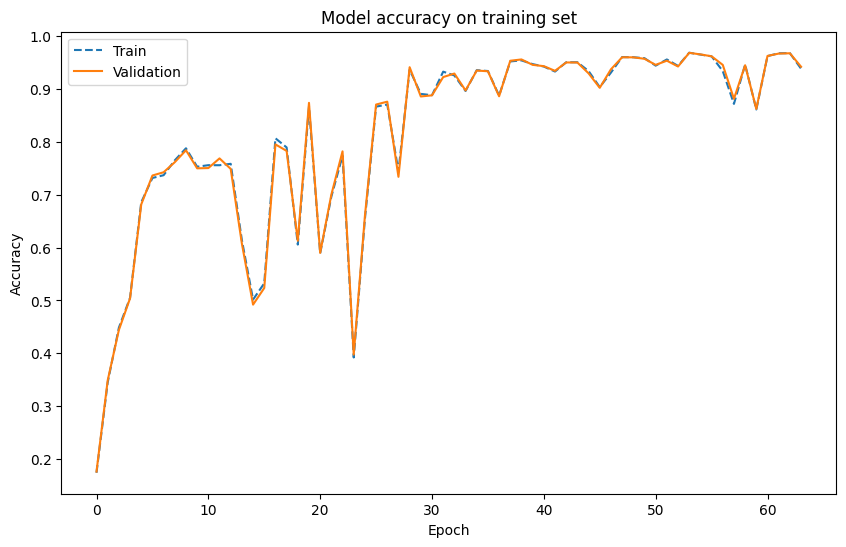

In [80]:
history = best_model.network.history

plt.figure(figsize=(10, 6))
plt.plot(history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(history['val_0_balanced_accuracy'], linestyle='--')
plt.plot(history['val_1_balanced_accuracy'])
plt.title('Model accuracy on training set')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()